### Disclaimer: This code is supposed to communicate with Azure in order to download and upload images. It, therefore, needs a private-key (connection_string), and thus will not be executable.

In [31]:
from azure.storage.blob import BlobServiceClient
import cv2
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageStat
import random

In [32]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [33]:
train = pd.read_csv('METER_ML_train.csv')

In [34]:
train

,Image_Folder,Type,Type_encoded
0,samples/train_images/43.94827109_-93.6494963.png,CAFOs,0
1,samples/train_images/43.00443446102501_-78.208...,Negative,3
2,samples/train_images/38.616_-77.27.png,WWTreatment,6
3,samples/train_images/44.67296_-95.15357.png,CAFOs,0
4,samples/train_images/43.923_-111.611.png,WWTreatment,6
...,...,...,...
84688,samples/train_images/44.80524_-94.47105.png,CAFOs,0
84689,samples/train_images/44.16770714709075_-74.564...,Negative,3
84690,samples/train_images/42.74134074771054_-78.958...,Negative,3
84691,samples/train_images/32.47265711491153_-94.394...,Mines,2


# Check label distribution

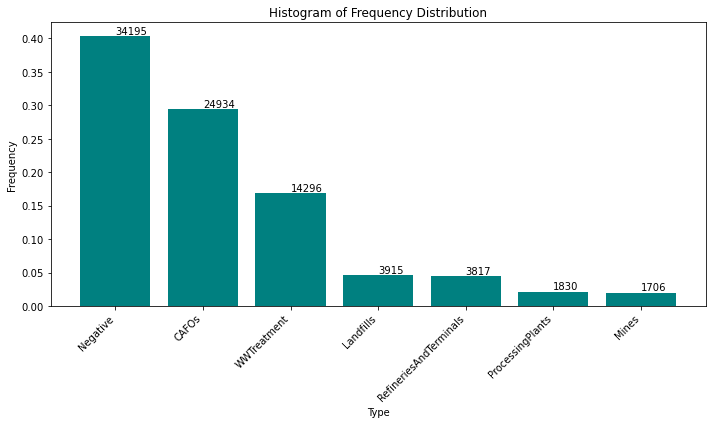

In [35]:
#group to count label occurence
train_dist = train.groupby("Type").count().reset_index()
train_dist_v2 = train_dist[["Type", "Type_encoded"]]
train_dist_v2 = train_dist_v2.sort_values("Type_encoded", ascending=False)


#count the number of rows in the dataset
n = train.shape[0]

#calculate the realtive frequency of each label
train_dist["Frequency"] = train_dist["Type_encoded"]/n
train_dist = train_dist[["Type", "Frequency"]].sort_values("Frequency", ascending=False)
train_dist


#display histogram of the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(train_dist['Type'], train_dist['Frequency'], color='teal')

#add counts above the bars
for bar, count in zip(bars, train_dist_v2['Type_encoded']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, count, va='bottom')  # va='bottom' to place text above the bar

plt.title('Histogram of Frequency Distribution')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

This shows a significant imbalance which needs to be coped with.

Based on the absolute numbers above, 10.000 instances per label seems like a reasonable quantity.

## Setting up the Balancing

In [36]:
#number of needed instances per label
x = 2000

train_count = train_dist_v2.rename(columns={"Type_encoded": "Count"})

#calculate the deficit or surplus of instances per label
train_count["Deficit"] = x - train_count["Count"]
#need for augmentation if deficit is positive
train_count["Augment"] = [False if deficit < 0 else True for deficit in train_count["Deficit"]]
#
train_count["Factor"] = [round(x/c, 2) for aug, c, d in zip(train_count["Augment"], train_count["Count"], train_count["Deficit"])]

train_count



,Type,Count,Deficit,Augment,Factor
3,Negative,34195,-32195,False,0.06
0,CAFOs,24934,-22934,False,0.08
6,WWTreatment,14296,-12296,False,0.14
1,Landfills,3915,-1915,False,0.51
5,RefineriesAndTerminals,3817,-1817,False,0.52
4,ProcessingPlants,1830,170,True,1.09
2,Mines,1706,294,True,1.17


In [37]:
# Function to calculate average brightness
def calculate_brightness(image):
    grayscale_image = image.convert("L")
    pixel_values = np.array(grayscale_image)
    return np.mean(pixel_values)

# Function to calculate contrast
def calculate_contrast(image):
    grayscale_image = image.convert("L")
    stat = ImageStat.Stat(grayscale_image)
    return stat.stddev[0]

# Create a list to store filenames that need to be removed
files_to_remove = []

# Process each blob
blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".jpg") and blob.name.startswith("samples/train_images"):
        print(f"Processing {blob.name}")
        blob_client = container_client.get_blob_client(blob.name)
        blob_data = blob_client.download_blob().readall()
        image_data = io.BytesIO(blob_data)
        image = Image.open(image_data)

        # Calculate brightness and contrast
        brightness = calculate_brightness(image)
        contrast = calculate_contrast(image)

        print(f"Brightness: {brightness}, Contrast: {contrast}")

        # Check if the image meets the removal criteria
        if brightness < 60 or contrast < 30 or brightness > 220:
            files_to_remove.append(blob.name)

print("Number of images to remove due to low quality: ", len(files_to_remove))

Number of images to remove due to low quality:  0


Since there are no images of low quality, as can be seen above, there must not be any additional cleaning of the dataset.

The Factor represents the multiplicator necessary to bring the sample size to ~10000.


In [38]:
def downsample(df, metadata):
    ds = pd.DataFrame(columns=['Image_Folder', 'Type', 'Type_encoded'])

    meta_ds = metadata[metadata["Augment"] == False]
    labels_ds = meta_ds['Type'].unique().tolist()

    for label in labels_ds:
        #just use data of certian label
        df_label = df[df["Type"] == label]
        
        #keep 2000 rows
        down_samp = df_label.sample(n=2000, random_state=42)

        #add the downsampled data to the dataset
        ds = pd.concat([ds, down_samp], ignore_index=True)
    
    meta_nds = metadata[metadata["Augment"] == True]
    labels_nds = meta_nds['Type'].unique().tolist()
    
    for label in labels_nds:
        df_label = df[df["Type"] == label]
        ds = pd.concat([ds, df_label], ignore_index=True)


    return ds

downsampled = downsample(train, train_count)
downsampled

downsampled.to_csv('METER_ML_train_downsampled.csv', index=False)


### Defining  the Augmentation function

In [39]:
def upload_png_to_blob(image, file_name):
    blob_name = f"augmented_final/{file_name}"
    blob_client = container_client.get_blob_client(blob_name)
    success, encoded_image = cv2.imencode('.png', image)
    if not success:
        print(f"Error encoding image: {file_name}")
        return None
    try:
        blob_client.upload_blob(encoded_image.tobytes(), overwrite=True)
        return blob_name
    except Exception as e:
        print(f"Error uploading image {file_name} to blob: {str(e)}")
        return None

def horizontal_flip(image):
    return cv2.flip(image, 1)

def vertical_flip(image):
    return cv2.flip(image, 0)

def rotate_90_clockwise(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

def increase_brightness_and_saturation(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:, :, 1] += 25  # Add to saturation
    hsv_image[:, :, 2] += 15  # Add to brightness
    hsv_image = np.clip(hsv_image, 0, 255)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

def add_gaussian_noise(image):
    noise = np.random.normal(loc=0.0, scale=25.0, size=image.shape)
    noisy_image = image.astype(np.float32) + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

def random_augment(image):
    methods = [
        horizontal_flip,
        vertical_flip,
        rotate_90_clockwise,
        increase_brightness_and_saturation,
        add_gaussian_noise
    ]

    try:
        # Randomly choose two different methods and apply them sequentially
        chosen_methods = random.sample(methods, 2)
        augmented_image = chosen_methods[0](image)
        augmented_image = chosen_methods[1](augmented_image)

        # Check if the augmentation resulted in an empty image
        if augmented_image.size == 0:
            print("Augmentation resulted in an empty image.")
            return None
        return augmented_image
    except Exception as e:
        print(f"An error occurred during augmentation: {str(e)}")
        return None


# Function to process images for a given type
def process_images_for_type(df, image_type, needed_augmentations, container_client, counter):
    # Filter DataFrame for the given type
    df_type = df[df['Type'] == image_type]

    # Initialize counters
    augmented_image_counter = counter
    augmented_counts = 0
    augmentations_needed = needed_augmentations[image_type]
    print(augmentations_needed)

    # List to store results
    results = []
    while df_type.shape[0] < augmentations_needed:
        df_type = pd.concat([df_type, df_type], ignore_index=True)
    print(df_type.shape)

    # Main loop for image processing
    for index, row in df_type.iterrows():
        if augmented_counts < augmentations_needed:
            file_name = row['Image_Folder']
            file_path = file_name  # Adjust based on actual path format in CSV
            print(file_path)
            # Download and decode the image
            blob = container_client.download_blob(file_path).readall()
            nparr = np.frombuffer(blob, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            if image is None or image.size == 0:
                print(f"Error: Failed to decode image from blob storage for path {file_path}")
            else:
                # Perform random augmentation
                augmented_image = random_augment(image)
                if augmented_image is not None and augmented_image.size != 0:
                    augmented_file_name = f"{augmented_image_counter:05}.png"
                    # Upload the augmented image back to blob
                    result = upload_png_to_blob(augmented_image, augmented_file_name)
                    if result:
                        blob_name = result
                        print(f"Uploaded: {blob_name}, Type: {image_type}")
                        results.append({'Image_Folder': blob_name, 'Type': image_type})
                        augmented_image_counter += 1
                        augmented_counts += 1

    # Convert results to DataFrame and return
    return pd.DataFrame(results)

### Setting up number needed for augmentation

In [40]:
df = pd.read_csv('METER_ML_train_downsampled.csv')
type_counts = df['Type'].value_counts()
needed_augmentations = (2000 - type_counts).to_dict()

In [ ]:
cafos_df = process_images_for_type(df, "CAFOs", needed_augmentations, container_client, 0)
cafos_df.to_csv("save/cafos.csv")

wwt_df = process_images_for_type(df, "WWTreatment", needed_augmentations, container_client, 2001)
wwt_df.to_csv("save/wwt.csv")

lf_df = process_images_for_type(df, "Landfills", needed_augmentations, container_client, 4001)
lf_df.to_csv("save/lf.csv")

rat_df = process_images_for_type(df, "RefineriesAndTerminals", needed_augmentations, container_client, 10086)
rat_df.to_csv("save/rat.csv")

pp_df = process_images_for_type(df, "ProcessingPlants", needed_augmentations, container_client, 12269)
pp_df.to_csv("save/pp.csv")

mines_df = process_images_for_type(df, "Mines", needed_augmentations, container_client, 16438)
mines_df.to_csv("save/mines.csv")

negative_df = process_images_for_type(df, "Negative", needed_augmentations, container_client, 20732)
negative_df.to_csv("save/negative.csv")